In [1]:
import os.path
import math
import re
import tensorflow as tf
import numpy as np
import facenet
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [460]:
def get_model_filenames(model_dir):
    files = os.listdir(model_dir)
    meta_files = [s for s in files if s.endswith('.meta')]
    if len(meta_files)==0:
        raise ValueError('No meta file found in the model directory (%s)' % model_dir)
    elif len(meta_files)>1:
        raise ValueError('There should not be more than one meta file in the model directory (%s)' % model_dir)
    meta_file = meta_files[0]
    meta_files = [s for s in files if '.ckpt' in s]
    max_step = -1
    for f in files:
        step_str = re.match(r'(^model-[\w\- ]+.ckpt-(\d+))', f)
        if step_str is not None and len(step_str.groups())>=2:
            step = int(step_str.groups()[1])
            if step > max_step:
                max_step = step
                ckpt_file = step_str.groups()[0]
    return meta_file, ckpt_file

def load_model(model, sess):
    model_exp = os.path.expanduser(model)
    print('Model directory: %s' % model_exp)
    meta_file, ckpt_file = get_model_filenames(model_exp)

    print('Metagraph file: %s' % meta_file)
    print('Checkpoint file: %s' % ckpt_file)

    saver = tf.train.import_meta_graph(os.path.join(model_exp, meta_file))
    saver.restore(sess, os.path.join(model_exp, ckpt_file))

In [461]:
def forward(paths, batch_size):
    nrof_images = len(paths)
    nrof_batches = int(math.ceil(1.0*nrof_images / batch_size))
    emb_array = np.zeros((nrof_images, embedding_size))

    for i in range(nrof_batches):    
        start_index = i*batch_size
        end_index = min((i+1)*batch_size, nrof_images)
        paths_batch = paths[start_index:end_index]
        images = facenet.load_data(paths_batch, False, False, image_size)
        feed_dict = { images_placeholder:images, phase_train_placeholder:False }
        emb_array[start_index:end_index,:] = sess.run(embeddings, feed_dict=feed_dict)    
        print("batch number:", i)
    print("Complete")
    
    return emb_array

def printDistance(emb_array, label_list, end=10):
    threshold = 1.0
    lng = len(emb_array[:end])
    print('Distance matrix')
    print('    ', end='')
    for i in range(lng):
        print('    %3d     ' % i, end='')
    print('')
    for i in range(lng):
        print('%1d  ' % i, end='')
        for j in range(lng):
            dist = np.linalg.norm(emb_array[i,:] - emb_array[j,:])
            print('  %1.4f' % dist, end='')
            if (label_list[i] == label_list[j]) and (dist <= threshold):
                print("(TP)", end='')
            elif (label_list[i] != label_list[j]) and (dist > threshold):
                print("(TN)", end='')
            elif (label_list[i] == label_list[j]) and (dist > threshold):
                print("\033[93m(FN)\033[0m", end='')
            elif (label_list[i] != label_list[j]) and (dist <= threshold):
                print("\033[93m(FP)\033[0m", end='')
        print('')
        
def printData(labels, paths, number):
    for i in range(number):
        if i > 0 and labels[i] != labels[i-1]:
            print('')
        print('{0:3d} {1:3d}   {2:s}'.format(i, labels[i], paths[i].split("\\")[1]))
        # print('{0:3d}   {1:s}'.format(labels[i], paths[i].split("\\")[1]))
        
def PCAtransform(emb_array, n_components = 10):
    pca = PCA(n_components, whiten=True)
    pca.fit(emb_array)
    return pca.transform(emb_array), pca

def splitTrainTest(data_set, percent_train):
    paths, labels_list = facenet.get_image_paths_and_labels(data_set)
    
    lng = len(paths)
    lng_train = int(lng * percent_train / 100);
    lng_test = lng - lng_train
    
    train_paths = paths[0:lng_train]
    test_paths = paths[lng_train:]
    
    train_labels = labels_list[0:lng_train]
    test_labels = labels_list[lng_train:]
    
    return train_paths, train_labels, test_paths, test_labels

def trainFisher(emb_array, y):
    emb_del = np.empty_like(emb_array)
    np.copyto(emb_del, emb_array)
    
    emb_array = np.vstack((emb_array, y))
    
    # y = emb_array[sample_number]
    # emb_del = np.delete(emb_array, (sample_number), axis=0)
    
    E = np.linalg.inv(np.cov(emb_array.T))
    D = (y - (1 / (len(emb_array) - 1) * np.sum(emb_del)))
    
    w = np.dot(E, D)
    c = np.dot(w / np.linalg.norm(w), y)
    
    return c, w

   

def Fisher(w, c, sample):
    return np.dot(w / np.linalg.norm(w), sample) - c

In [4]:
sess = tf.Session()

In [5]:
data_set = facenet.get_dataset("../../datasets/lfw/lfw_mtcnnpy_160/")

In [6]:
train_paths, train_labels, test_paths, test_labels = splitTrainTest(data_set, 100)

In [7]:
load_model("20170511-185253", sess)

Model directory: 20170511-185253
Metagraph file: model-20170511-185253.meta
Checkpoint file: model-20170511-185253.ckpt-80000
'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from 20170511-185253\model-20170511-185253.ckpt-80000


In [8]:
images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")

image_size = 160
embedding_size = embeddings.get_shape()[1]

In [9]:
emb_array = forward(train_paths, 100) # 100 means 100 mini-batches

batch number: 0
batch number: 1
batch number: 2
batch number: 3
batch number: 4
batch number: 5
batch number: 6
batch number: 7
batch number: 8
batch number: 9
batch number: 10
batch number: 11
batch number: 12
batch number: 13
batch number: 14
batch number: 15
batch number: 16
batch number: 17
batch number: 18
batch number: 19
batch number: 20
batch number: 21
batch number: 22
batch number: 23
batch number: 24
batch number: 25
batch number: 26
batch number: 27
batch number: 28
batch number: 29
batch number: 30
batch number: 31
batch number: 32
batch number: 33
batch number: 34
batch number: 35
batch number: 36
batch number: 37
batch number: 38
batch number: 39
batch number: 40
batch number: 41
batch number: 42
batch number: 43
batch number: 44
batch number: 45
batch number: 46
batch number: 47
batch number: 48
batch number: 49
batch number: 50
batch number: 51
batch number: 52
batch number: 53
batch number: 54
batch number: 55
batch number: 56
batch number: 57
batch number: 58
batch n

In [10]:
# t = TSNE(n_components=2).fit_transform(emb_array)

In [273]:
cv = np.array([[2.0, 0.8], [0.8, 0.6]])
mn = np.array([1., 1.])

rd = np.random.multivariate_normal(mn, cv, 400)

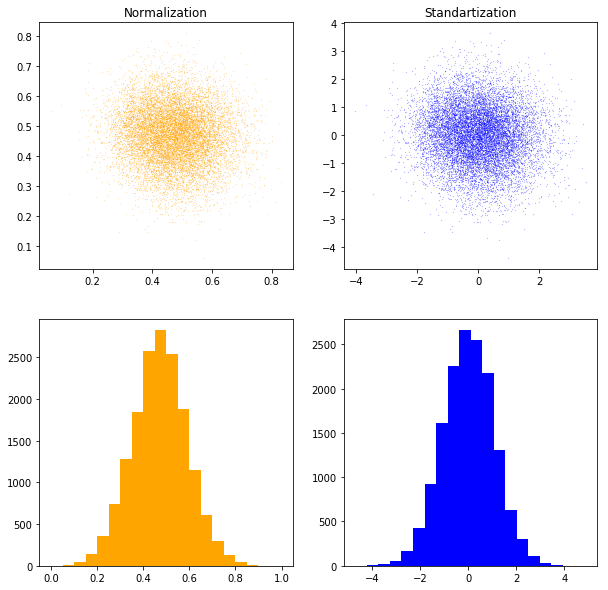

In [462]:
t = emb_array
w1 = 0
w2 = 1

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
s_ = 0.01

# Centering
tc = t - np.mean(t, axis=0)
#ax1.scatter(tc[:, 0], tc[:, 1], c="r", s=0.01)

# Normalization
tn = (tc - tc.min()) / (tc.max() - tc.min())
ax1.scatter(tn[:, w1], tn[:, w2], c="orange", s=s_)
ax1.set_title("Normalization")

# Standartization
ts = tc / tc.std(axis=0)
ax2.scatter(ts[:, w1], ts[:, w2], c="b", s=s_)
ax2.set_title("Standartization")

# Histograms
n, bins, rectangles = ax3.hist(tn, bins=20, facecolor="orange", histtype="stepfilled")
n, bins, rectangles = ax4.hist(ts, bins=20, facecolor="blue", histtype="stepfilled")

plt.savefig('difference.png')

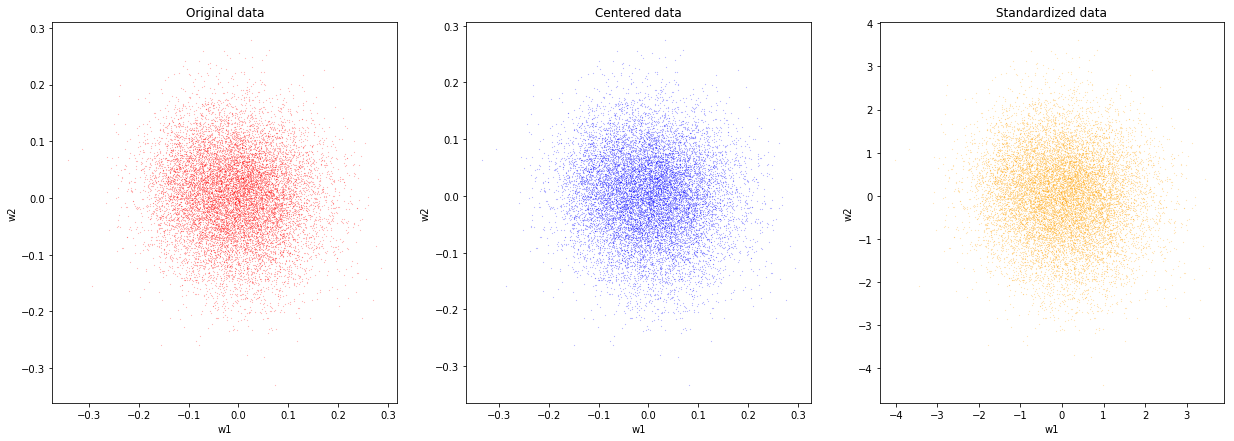

In [463]:
fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(21,7))

# Original data
ax1.set_title("Original data")
ax1.scatter(t[:, w1], t[:, w2], c="red", s=s_)
ax1.set_xlabel("w1")
ax1.set_ylabel("w2")

# Centered data
ax2.set_title("Centered data")
ax2.scatter(tc[:, w1], tc[:, w2], c="b", s=s_)
ax2.set_xlabel("w1")
ax2.set_ylabel("w2")

# Standardized data
ax3.set_title("Standardized data")
ax3.scatter(ts[:, w1], ts[:, w2], c="orange", s=s_)
ax3.set_xlabel("w1")
ax3.set_ylabel("w2")

plt.savefig('preprocess.png')

In [464]:
# Current working matrix
X = ts

In [465]:
cov = np.cov(X.T)

In [466]:
# Trace of covariance matrix (must be == cov.shape[0])
print(cov.shape[0], np.trace(cov))

128 128.009673519


In [467]:
eig_vals, eig_vecs = np.linalg.eig(cov)

In [468]:
print(eig_vecs.shape)

(128, 128)


In [469]:
for ev in eig_vecs:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')

Everything ok!


In [470]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()

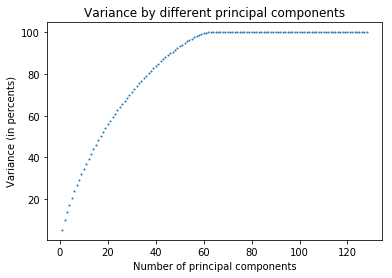

In [471]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

x_ = [i for i in range(1,129)]

plt.scatter(x=x_, y=cum_var_exp, s=1)
plt.title("Variance by different principal components")
plt.xlabel("Number of principal components")
plt.ylabel("Variance (in percents)")
plt.savefig('variance.png')

In [472]:
pca_matrix = eig_pairs[0][1].reshape(128, 1)
num_components = 70

for i in range(1, num_components):
    pca_matrix = np.hstack((pca_matrix,
                            eig_pairs[i][1].reshape(128, 1)))

In [473]:
pca_matrix.shape

(128, 70)

In [474]:
X_pca = X.dot(pca_matrix)

In [475]:
# Whitening
X_whit = X_pca / np.sqrt(eig_vals[:70])

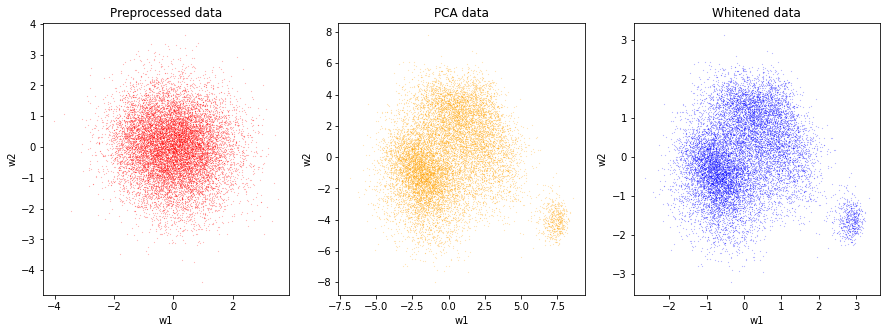

In [476]:
fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

# Original data
ax1.set_title("Preprocessed data")
ax1.scatter(X[:, w1], X[:, w2], c="red", s=s_)
ax1.set_xlabel("w1")
ax1.set_ylabel("w2")

# PCA data
ax2.set_title("PCA data")
ax2.scatter(X_pca[:, w1], X_pca[:, w2], c="orange", s=s_)
ax2.set_xlabel("w1")
ax2.set_ylabel("w2")

# Whitened data
ax3.set_title("Whitened data")
ax3.scatter(X_whit[:, w1], X_whit[:, w2], c="b", s=s_)
ax3.set_xlabel("w1")
ax3.set_ylabel("w2")

plt.savefig("whitening.png")

In [477]:
printData(train_labels, train_paths, 20)

  0   0   AJ_Cook_0001.png

  1   1   AJ_Lamas_0001.png

  2   2   Aaron_Eckhart_0001.png

  3   3   Aaron_Guiel_0001.png

  4   4   Aaron_Patterson_0001.png

  5   5   Aaron_Peirsol_0001.png
  6   5   Aaron_Peirsol_0002.png
  7   5   Aaron_Peirsol_0003.png
  8   5   Aaron_Peirsol_0004.png

  9   6   Aaron_Pena_0001.png

 10   7   Aaron_Sorkin_0001.png
 11   7   Aaron_Sorkin_0002.png

 12   8   Aaron_Tippin_0001.png

 13   9   Abba_Eban_0001.png

 14  10   Abbas_Kiarostami_0001.png

 15  11   Abdel_Aziz_Al-Hakim_0001.png

 16  12   Abdel_Madi_Shabneh_0001.png

 17  13   Abdel_Nasser_Assidi_0001.png
 18  13   Abdel_Nasser_Assidi_0002.png

 19  14   Abdoulaye_Wade_0001.png


In [478]:
X_work = np.delete(X_whit, (6, 7, 8), axis=0)

In [479]:
c, w = trainFisherWithNum(X_work, 5)

In [488]:
lng = len(X_whit)
summ = 0
thr = 0.0

for i in range(lng):
    l = Fisher(w, 0.5, X_whit[i]/np.linalg.norm(X_whit[i]))
    if l > thr and train_labels[i] == 5:
        summ += 1
        print(l)
    elif l < thr and train_labels[i] != 5:
        summ += 1
        #print(l)
    else:
        print(i, l, train_labels[i])

print('')
print("Accuracy:", summ / lng)

0.394987337513
0.21645551138
0.242586199217
8 -0.0106393010273 5

Accuracy: 0.9999244313458777


In [ ]:
tra